<a href="https://colab.research.google.com/github/AYYAPPADAS2123/tumor/blob/master/breast_cancer.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))


Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 68 bytes


In [2]:

# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json


In [3]:
!kaggle datasets download -d uzairkhan45/breast-cancer-patients-mris

Dataset URL: https://www.kaggle.com/datasets/uzairkhan45/breast-cancer-patients-mris
License(s): CC0-1.0
 95% 54.0M/56.9M [00:01<00:00, 65.8MB/s]
100% 56.9M/56.9M [00:01<00:00, 52.3MB/s]


In [21]:
import tensorflow as tf
from zipfile import ZipFile
import os,glob
import cv2
from tqdm._tqdm_notebook import tqdm_notebook as tqdm
import numpy as np
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Convolution2D, Dropout, Dense,MaxPooling2D
from keras.layers import BatchNormalization
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from sklearn.preprocessing import LabelEncoder

In [22]:


from zipfile import ZipFile
file_name = "/content/breast-cancer-patients-mris.zip"
with ZipFile(file_name,'r') as zip:
  zip.extractall()
  print('Done')

Done


In [27]:
# Initialize lists
X = []
y = []

# Define the classes and corresponding directories
classes = ['Healthy', 'Sick']
base_dir = "/content/Breast Cancer Patients MRI's/train"

for class_name in classes:
    class_dir = os.path.join(base_dir, class_name)
    os.chdir(class_dir)

    for i in tqdm(os.listdir()):
        img = cv2.imread(i)
        img = cv2.resize(img, (224, 224))
        X.append(img)
        y.append(class_name)  # Append the class name or label

print(y)



  0%|          | 0/700 [00:00<?, ?it/s]

  0%|          | 0/701 [00:00<?, ?it/s]

error: OpenCV(4.10.0) /io/opencv/modules/imgproc/src/resize.cpp:4152: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


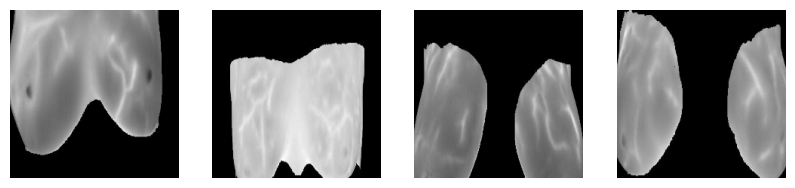

In [28]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 10))
for i in range(4):
    plt.subplot(1, 4, i+1)
    plt.imshow(X[i], cmap="gray")
    plt.axis('off')
plt.show()


In [29]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=42)
print ("Shape of an image in X_train: ", X_train[0].shape)
print ("Shape of an image in X_test: ", X_test[0].shape)


Shape of an image in X_train:  (224, 224, 3)
Shape of an image in X_test:  (224, 224, 3)


In [30]:

le = preprocessing.LabelEncoder()
y_train = le.fit_transform(y_train)
y_test = le.fit_transform(y_test)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=2)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=2)
y_train = np.array(y_train)
X_train = np.array(X_train)
y_test = np.array(y_test)
X_test = np.array(X_test)


In [31]:


print("X_train Shape: ", X_train.shape)
print("X_test Shape: ", X_test.shape)
print("y_train Shape: ", y_train.shape)
print("y_test Shape: ", y_test.shape)


X_train Shape:  (834, 224, 224, 3)
X_test Shape:  (411, 224, 224, 3)
y_train Shape:  (834, 2)
y_test Shape:  (411, 2)


In [32]:


from tensorflow.keras.applications import VGG19
from tensorflow.keras.layers import GlobalAveragePooling2D



In [33]:
img_rows, img_cols = 224, 224

In [34]:

vgg =VGG19(weights='imagenet',
                                  include_top=False,
                                  input_shape=(img_rows, img_cols, 3))
# Here we freeze the last 4 layers
# Layers are set to trainable as True by default
for layer in vgg.layers:
    layer.trainable = False

# Let's print our layers
for (i,layer) in enumerate(vgg.layers):
    print(str(i) + " "+ layer.__class__.__name__, layer.trainable)



0 InputLayer False
1 Conv2D False
2 Conv2D False
3 MaxPooling2D False
4 Conv2D False
5 Conv2D False
6 MaxPooling2D False
7 Conv2D False
8 Conv2D False
9 Conv2D False
10 Conv2D False
11 MaxPooling2D False
12 Conv2D False
13 Conv2D False
14 Conv2D False
15 Conv2D False
16 MaxPooling2D False
17 Conv2D False
18 Conv2D False
19 Conv2D False
20 Conv2D False
21 MaxPooling2D False


In [35]:

def lw(bottom_model, num_classes):
  """creates the top or head of the model that will be
  placed ontop of the bottom layers"""

  top_model = bottom_model.output
  top_model = GlobalAveragePooling2D()(top_model)
  top_model = Dense(1024,activation='relu')(top_model)
  top_model = Dense(1024,activation='relu')(top_model)
  top_model = Dense(512,activation='relu')(top_model)
  top_model = Dense(num_classes,activation='softmax')(top_model)
  return top_model

In [36]:

from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten, GlobalAveragePooling2D
from keras.layers import Conv2D, MaxPooling2D, ZeroPadding2D

from keras.models import Model


In [37]:

num_classes = 2

FC_Head = lw(vgg, num_classes)

model = Model(inputs = vgg.input, outputs = FC_Head)

print(model.summary())



Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv1 (Conv2D)                │ (None, 224, 224, 64)        │           1,792 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_conv2 (Conv2D)                │ (None, 224, 224, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block1_pool (MaxPooling2D)           │ (None, 112, 112, 64)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv1 (Conv2D)                │ (None, 112, 112, 128)       │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_conv2 (Conv2D)                │ (None, 112, 112, 128)       │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block2_pool (MaxPooling2D)           │ (None, 56, 56, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv1 (Conv2D)                │ (None, 56, 56, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv2 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv3 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_conv4 (Conv2D)                │ (None, 56, 56, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block3_pool (MaxPooling2D)           │ (None, 28, 28, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv1 (Conv2D)                │ (None, 28, 28, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv2 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv3 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_conv4 (Conv2D)                │ (None, 28, 28, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block4_pool (MaxPooling2D)           │ (None, 14, 14, 512)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv1 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv2 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv3 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ block5_conv4 (Conv2D)                │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 22,125,122 (84.40 MB)

 Trainable params: 2,100,738 (8.01 MB)

 Non-trainable params: 20,024,384 (76.39 MB)

None


In [38]:


from tensorflow.keras.models import Model

In [40]:
# Compile and train the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [41]:
training_history = model.fit(X_train,y_train,
                    epochs=5,
                    validation_data=(X_test,y_test),
                    verbose = 1,
                    initial_epoch=0)


Epoch 1/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 982s 37s/step - accuracy: 0.5286 - loss: 4.6960 - val_accuracy: 0.6813 - val_loss: 0.5892
Epoch 2/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 986s 37s/step - accuracy: 0.7494 - loss: 0.5205 - val_accuracy: 0.8905 - val_loss: 0.3013
Epoch 3/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 1028s 36s/step - accuracy: 0.8827 - loss: 0.2687 - val_accuracy: 0.8613 - val_loss: 0.2884
Epoch 4/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 981s 36s/step - accuracy: 0.9240 - loss: 0.1643 - val_accuracy: 0.9684 - val_loss: 0.1012
Epoch 5/5
27/27 ━━━━━━━━━━━━━━━━━━━━ 984s 36s/step - accuracy: 0.9863 - loss: 0.0501 - val_accuracy: 0.9878 - val_loss: 0.0504


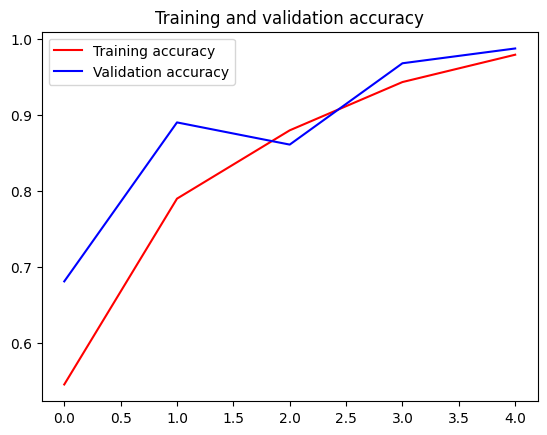

<Figure size 640x480 with 0 Axes>

In [42]:
import matplotlib.pyplot as plt
%matplotlib inline
acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']
loss = training_history.history['loss']
val_loss = training_history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

In [43]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=1)


13/13 ━━━━━━━━━━━━━━━━━━━━ 320s 25s/step - accuracy: 0.9918 - loss: 0.0427


In [44]:

# Print the test accuracy
print(f'Test accuracy: {test_accuracy * 100:.2f}%')


Test accuracy: 98.78%


In [45]:
# Predict the classes for the test set
y_pred = model.predict(X_test)


13/13 ━━━━━━━━━━━━━━━━━━━━ 319s 24s/step


In [47]:
# Convert predictions and true labels to their class indices
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)


In [48]:
# Generate a classification report
from sklearn.metrics import classification_report, confusion_matrix

print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes, target_names=classes))

# Generate and display the confusion matrix
print("Confusion Matrix:\n")
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)
print(conf_matrix)


Classification Report:

              precision    recall  f1-score   support

     Healthy       0.99      0.99      0.99       234
        Sick       0.99      0.98      0.99       177

    accuracy                           0.99       411
   macro avg       0.99      0.99      0.99       411
weighted avg       0.99      0.99      0.99       411

Confusion Matrix:

[[232   2]
 [  3 174]]


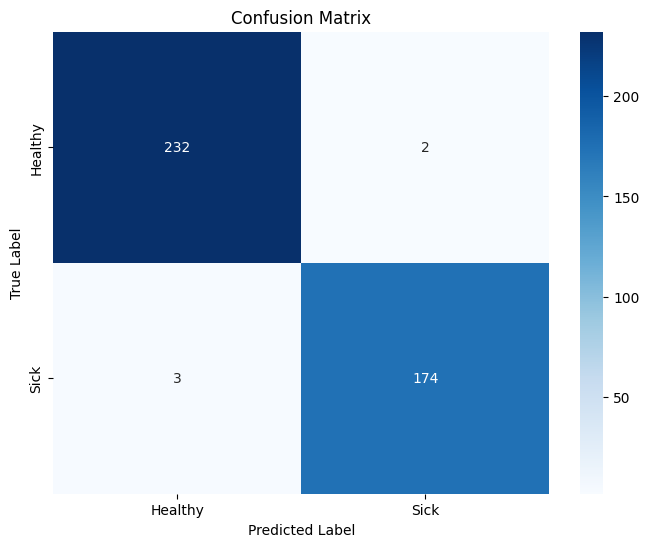

In [49]:
import seaborn as sns

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=classes, yticklabels=classes)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()